In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [157]:
!pip install --upgrade google-api-python-client

Requirement already up-to-date: google-api-python-client in c:\users\rohah\anaconda3\envs\jarvis\lib\site-packages (1.7.11)


In [ ]:

import io
from googleapiclient.http import MediaIoBaseDownload
DRIVE = discovery.build('drive', 'v3', http=creds.authorize(Http()))
# if you get the shareable link, the link contains this id, replace the file_id below
file_id = '1Vf8aByqXQwTVmxxs5jKenvAXaxSF6TsH'
request = DRIVE.files().get_media(fileId=file_id)
# replace the filename and extension in the first field below
fh = io.FileIO('wiki-news-300d-1M.vec', mode='w')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

In [156]:
from googleapiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools
obj = lambda: None
lmao = {"auth_host_name":'localhost', 'noauth_local_webserver':'store_true', 'auth_host_port':[8080, 8090], 'logging_level':'ERROR'}
for k, v in lmao.items():
    setattr(obj, k, v)
    
# authorization boilerplate code
SCOPES = 'https://www.googleapis.com/auth/drive.readonly'
store = file.Storage('token.json')
creds = store.get()
# The following will give you a link if token.json does not exist, the link allows the user to give this app permission
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('client_id.json', SCOPES)
    creds = tools.run_flow(flow, store, obj)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim  
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [3]:
embeddings_index = {}
f = codecs.open('./wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

999995it [02:28, 6736.45it/s]


found 999995 word vectors


In [5]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [6]:
def splitIntoStem(message):
    return [removeNumeric(stripEmoji(singleCharacterRemove(removePunctuation
                                                           (removeHyperlinks
                                                            (removeHashtags
                                                             (removeUsernames
                                                              (stemWord(word)))))))) for word in message.split()]
def stemWord(tweet):
    return tweet.lower()

def removeUsernames(tweet):
    return re.sub('@[^\s]+', '', tweet)

def removeHashtags(tweet):
    return re.sub(r'#[^\s]+', '', tweet)

def removeHyperlinks(tweet):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet)

def removeNumeric(value):
    blist2 = [item for item in value if not item.isdigit()]
    blist3 = "".join(blist2)
    return blist3

def removePunctuation(tweet):

    return re.sub(r'[^\w\s]','',tweet)

def singleCharacterRemove(tweet):
    return re.sub(r'(?:^| )\w(?:$| )', ' ', tweet)

def stripEmoji(text):

    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return RE_EMOJI.sub(r'', text)

In [51]:
tweets_df = pd.read_csv('./tweets.csv', sep=',', header=0)
tweet_list = tweets_df['tweet'].tolist()
# label_list = tweets_df['Label'].tolist()
# one_hot_labels = keras.utils.to_categorical(label_list, num_classes=4)
label_names = ["business", "entertainment", "health", "politics"]
labels = tweets_df[label_names].values

In [52]:
processed_list = []
for sentence in tqdm(tweet_list):
    tokens = " ".join(splitIntoStem(sentence)).split()
    filtered = [word for word in tokens if word not in stop_words]
    processed_list.append(" ".join(filtered))

100%|████████████████████████████████████████████████████████████████████████████| 1096/1096 [00:00<00:00, 8860.20it/s]


In [53]:
df = pd.DataFrame()
df["tweet"] = processed_list
df['doc_len'] = df['tweet'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
max_seq_len

12

In [54]:
# x_train, x_test, y_train, y_test = train_test_split(processed_list, one_hot_labels, test_size=0.35)
x_train, x_test, y_train, y_test = train_test_split(processed_list, labels, test_size=0.35)

In [88]:
len(x_train)

712

In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train + x_test)
word_seq_train = tokenizer.texts_to_sequences(x_train)
word_seq_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  4132


In [56]:
num_tokens = [len(tokens) for tokens in word_seq_train + word_seq_test]
num_tokens = np.array(num_tokens)
num_tokens

array([6, 2, 7, ..., 5, 7, 6])

In [57]:
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

In [58]:
word_seq_test = word_seq_test[:-1]
y_test = y_test[:-1]

In [79]:
#training params
batch_size = 256
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [60]:
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
embedding_matrix2 = np.zeros((nb_words, embed_dim))

In [61]:
words_not_found = []

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

number of null word embeddings: 329
sample words not found:  ['moviesong' 'csections' 'californias' 'poorna' 'freetoread'
 'epidemiologybiostatistics' 'eitc' 'dulhania' 'इरन' 'airbuss']


In [67]:
for word, i in word_index.items():
    if i >= nb_words:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix2[i] = embedding_vector
    except KeyError:
        embedding_matrix2[i]=np.random.normal(0,np.sqrt(0.25),embed_dim)

del(word_vectors)

In [80]:
model = Sequential()
model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(num_filters, 5, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 5, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 12, 300)           1239600   
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 300)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 12, 64)            96064     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 6, 64)             20544     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 64)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
__________

In [69]:
model2 = Sequential()
model2.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix2], input_length=max_seq_len, trainable=True))
model2.add(Dropout(0.2))
model2.add(Conv1D(num_filters, 5, padding='same', activation='relu', strides=1))
model2.add(MaxPooling1D(2))
model2.add(Conv1D(num_filters, 5, activation='relu', padding='same'))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 12, 300)           1239600   
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 300)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 12, 64)            96064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 6, 64)             20544     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
__________

In [100]:
history = model.fit(word_seq_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Train on 712 samples, validate on 383 samples
Epoch 1/8
712/712 [==============================] - ETA: 0s - loss: 1.0003 - acc: 0.601 - ETA: 0s - loss: 0.9798 - acc: 0.632 - 0s 321us/step - loss: 0.9606 - acc: 0.6461 - val_loss: 0.9090 - val_acc: 0.6789
Epoch 2/8
712/712 [==============================] - ETA: 0s - loss: 0.9412 - acc: 0.652 - ETA: 0s - loss: 0.9130 - acc: 0.687 - 0s 307us/step - loss: 0.8941 - acc: 0.6910 - val_loss: 0.8389 - val_acc: 0.7363
Epoch 3/8
712/712 [==============================] - ETA: 0s - loss: 0.8281 - acc: 0.703 - ETA: 0s - loss: 0.8398 - acc: 0.693 - 0s 343us/step - loss: 0.8182 - acc: 0.7121 - val_loss: 0.7719 - val_acc: 0.7702
Epoch 4/8
712/712 [==============================] - ETA: 0s - loss: 0.7940 - acc: 0.710 - ETA: 0s - loss: 0.7711 - acc: 0.726 - 0s 345us/step - loss: 0.7518 - acc: 0.7444 - val_loss: 0.7029 - val_acc: 0.8068
Epoch 5/8
712/712 [==============================] - ETA: 0s - loss: 0.7242 - acc: 0.753 - ETA: 0s - loss: 0.7111 - ac

In [101]:
history2 = model2.fit(word_seq_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Train on 712 samples, validate on 383 samples
Epoch 1/8
712/712 [==============================] - ETA: 0s - loss: 1.3159 - acc: 0.378 - ETA: 0s - loss: 1.2953 - acc: 0.416 - 0s 362us/step - loss: 1.2881 - acc: 0.4228 - val_loss: 1.3082 - val_acc: 0.4439
Epoch 2/8
712/712 [==============================] - ETA: 0s - loss: 1.2707 - acc: 0.457 - ETA: 0s - loss: 1.2710 - acc: 0.453 - 0s 359us/step - loss: 1.2775 - acc: 0.4537 - val_loss: 1.2833 - val_acc: 0.4830
Epoch 3/8
712/712 [==============================] - ETA: 0s - loss: 1.2477 - acc: 0.500 - ETA: 0s - loss: 1.2482 - acc: 0.464 - 0s 365us/step - loss: 1.2375 - acc: 0.4972 - val_loss: 1.2538 - val_acc: 0.5300
Epoch 4/8
712/712 [==============================] - ETA: 0s - loss: 1.2082 - acc: 0.507 - ETA: 0s - loss: 1.2141 - acc: 0.523 - 0s 410us/step - loss: 1.2197 - acc: 0.5169 - val_loss: 1.2166 - val_acc: 0.5744
Epoch 5/8
712/712 [==============================] - ETA: 0s - loss: 1.1769 - acc: 0.535 - ETA: 0s - loss: 1.1617 - ac

In [103]:
model.evaluate(word_seq_test, y_test)

383/383 [==============================] - ETA:  - ETA:  - 0s 224us/step


[0.5280586859264822, 0.8381201024155082]

In [104]:
model2.evaluate(word_seq_test, y_test)

383/383 [==============================] - ETA:  - ETA:  - 0s 206us/step


[0.9874114319487589, 0.6997389041723844]

In [131]:
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
acc1 = history.history['acc']
val_acc1 = history.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']

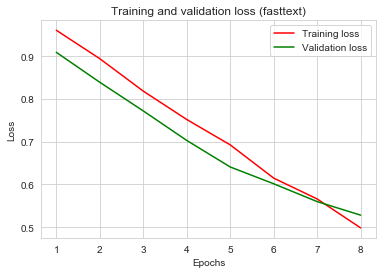

In [132]:
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss1, color='red', label='Training loss')
plt.plot(epochs, val_loss1, color='green', label='Validation loss')
plt.title('Training and validation loss (fasttext)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

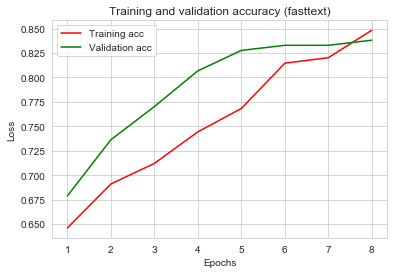

In [133]:
plt.plot(epochs, acc1, color='red', label='Training acc')
plt.plot(epochs, val_acc1, color='green', label='Validation acc')
plt.title('Training and validation accuracy (fasttext)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

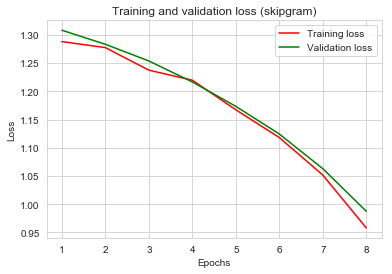

In [134]:
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss2, color='red', label='Training loss')
plt.plot(epochs, val_loss2, color='green', label='Validation loss')
plt.title('Training and validation loss (skipgram)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

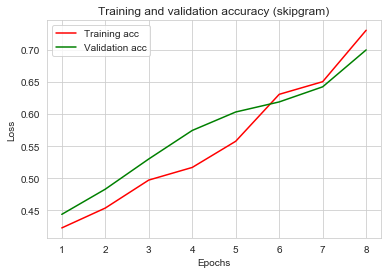

In [135]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
plt.plot(epochs, acc2, color='red', label='Training acc')
plt.plot(epochs, val_acc2, color='green', label='Validation acc')
plt.title('Training and validation accuracy (skipgram)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

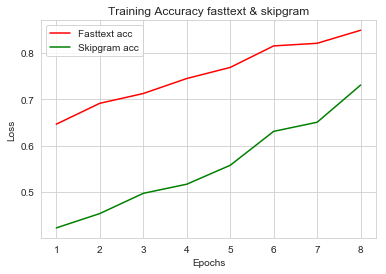

In [136]:
plt.plot(epochs, acc1, color='red', label='Fasttext acc')
plt.plot(epochs, acc2, color='green', label='Skipgram acc')
plt.title('Training Accuracy fasttext & skipgram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

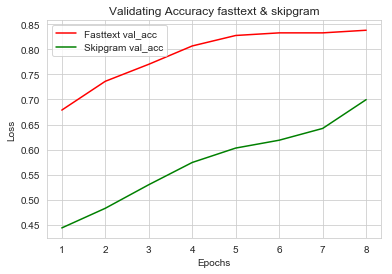

In [155]:
plt.plot(epochs, val_acc1, color='red', label='Fasttext val_acc')
plt.plot(epochs, val_acc2, color='green', label='Skipgram val_acc')
plt.title('Validating Accuracy fasttext & skipgram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

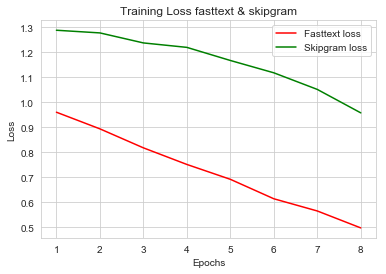

In [138]:
plt.plot(epochs, loss1, color='red', label='Fasttext loss')
plt.plot(epochs, loss2, color='green', label='Skipgram loss')
plt.title('Training Loss fasttext & skipgram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

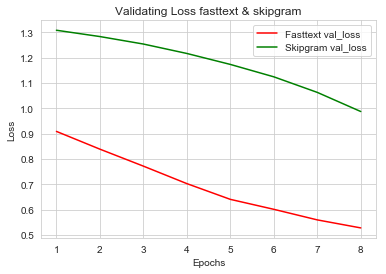

In [152]:
plt.plot(epochs, val_loss1, color='red', label='Fasttext val_loss')
plt.plot(epochs, val_loss2, color='green', label='Skipgram val_loss')
plt.title('Validating Loss fasttext & skipgram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [145]:
model3 = Sequential()
model3.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix2], input_length=max_seq_len, trainable=True))
model3.add(Dropout(0.2))
model3.add(Conv1D(num_filters, 5, padding='same', activation='relu', strides=1))
model3.add(MaxPooling1D(2))
model3.add(Conv1D(num_filters, 5, activation='relu', padding='same'))
model3.add(MaxPooling1D(2))
model3.add(Conv1D(num_filters, 5, activation='relu', padding='same'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.5))
model3.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model3.add(Dense(4, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 12, 300)           1239600   
_________________________________________________________________
dropout_19 (Dropout)         (None, 12, 300)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 12, 64)            96064     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 6, 64)             20544     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 3, 64)             20544     
__________

In [146]:
history3 = model3.fit(word_seq_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Train on 712 samples, validate on 383 samples
Epoch 1/8
712/712 [==============================] - ETA: 3s - loss: 1.4332 - acc: 0.207 - ETA: 0s - loss: 1.4201 - acc: 0.209 - 2s 3ms/step - loss: 1.4136 - acc: 0.2121 - val_loss: 1.3814 - val_acc: 0.3029
Epoch 2/8
712/712 [==============================] - ETA: 0s - loss: 1.3836 - acc: 0.328 - ETA: 0s - loss: 1.3697 - acc: 0.339 - 0s 361us/step - loss: 1.3690 - acc: 0.3357 - val_loss: 1.3711 - val_acc: 0.2977
Epoch 3/8
712/712 [==============================] - ETA: 0s - loss: 1.3535 - acc: 0.394 - ETA: 0s - loss: 1.3541 - acc: 0.396 - 0s 373us/step - loss: 1.3533 - acc: 0.3904 - val_loss: 1.3493 - val_acc: 0.3499
Epoch 4/8
712/712 [==============================] - ETA: 0s - loss: 1.3288 - acc: 0.394 - ETA: 0s - loss: 1.3192 - acc: 0.445 - 0s 388us/step - loss: 1.3156 - acc: 0.4340 - val_loss: 1.3035 - val_acc: 0.4856
Epoch 5/8
712/712 [==============================] - ETA: 0s - loss: 1.2830 - acc: 0.535 - ETA: 0s - loss: 1.2739 - acc:

In [147]:
model3.evaluate(word_seq_test, y_test)

383/383 [==============================] - ETA:  - ETA:  - 0s 276us/step


[0.8323093669844047, 0.7336814629191207]

In [148]:
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']

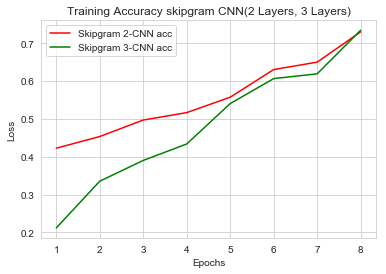

In [154]:
plt.plot(epochs, acc2, color='red', label='Skipgram 2-CNN acc')
plt.plot(epochs, acc3, color='green', label='Skipgram 3-CNN acc')
plt.title('Training Accuracy skipgram CNN(2 Layers, 3 Layers)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

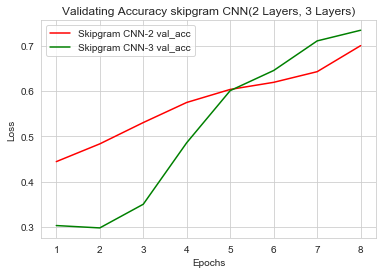

In [153]:
plt.plot(epochs, val_acc2, color='red', label='Skipgram CNN-2 val_acc')
plt.plot(epochs, val_acc3, color='green', label='Skipgram CNN-3 val_acc')
plt.title('Validating Accuracy skipgram CNN(2 Layers, 3 Layers)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()